In [99]:
import pandas
import konlpy
import gensim
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1) 데이터 준비와 확인

In [100]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [101]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


# 2) 데이터로더 구성

In [102]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=None):
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')
    
    # 한국어 토크나이저로 토큰화하고 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    if num_words is None:
        num_words = len(counter)
    else:
        num_words = num_words
    word_to_index = {word: index + 4 for index, word in enumerate(counter)}
    word_to_index["<PAD>"] = 0  # 패딩용 단어
    word_to_index["<BOS>"] = 1  # 시작 토큰
    word_to_index["<EOS>"] = 2  # 종료 토큰
    word_to_index["<UNK>"] = 3  # OOV(Out Of Vocabulary)
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
    
    return X_train, y_train, X_test, y_test, word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [103]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [104]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공

In [105]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[4, 5, 6, 7, 7, 8, 9, 10, 11, 12]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [106]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [107]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4) 모델 구성 및 validation set 구성

In [108]:
# 1번째 모델 1-D CNN

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_CNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력 레이어
])
model_CNN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 39, 32)            9632      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 17, 32)            3104      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [109]:
# 2번째 모델 GlobalMaxPooling1D()만

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_MAX = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력 레이어
])
model_MAX.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [110]:
# 3번째 모델 RNN

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_RNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(units=8),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력 레이어
])
model_RNN.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 8)                 872       
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
Total params: 1,000,913
Trainable params: 1,000,913
Non-trainable params: 0
_________________________________________________________________


In [111]:
#X_train.shape -> (146182, 41)
#y_train.shaep -> (146182,)

# validation set 50000건 분리
x_val = X_train[:50000]
y_val = y_train[:50000]

# validation set을 제외한 나머지 96182건
partial_x_train = X_train[50000:]
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


# 5) 모델 훈련 개시

In [112]:
def train_model(model, partial_x_train, partial_y_train, x_val, y_val, batch_size, epochs=20):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    return history


In [113]:
history_CNN = train_model(model_CNN, partial_x_train, partial_y_train, x_val, y_val, epochs=20, batch_size=512)

Epoch 1/20
188/188 [==============================] - 2s 7ms/step - loss: 0.4652 - accuracy: 0.7793 - val_loss: 0.3549 - val_accuracy: 0.8439
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3248 - accuracy: 0.8618 - val_loss: 0.3476 - val_accuracy: 0.8493
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2851 - accuracy: 0.8819 - val_loss: 0.3479 - val_accuracy: 0.8496
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2486 - accuracy: 0.9005 - val_loss: 0.3626 - val_accuracy: 0.8479
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2118 - accuracy: 0.9179 - val_loss: 0.3792 - val_accuracy: 0.8460
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.1713 - accuracy: 0.9368 - val_loss: 0.4263 - val_accuracy: 0.8400
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.1330 - accuracy: 0.9536 - val_loss: 0.4693 - val_accuracy: 0.8363
Epoch 

In [114]:
history_MAX = train_model(model_MAX, partial_x_train, partial_y_train, x_val, y_val, epochs=20, batch_size=512)

Epoch 1/20
188/188 [==============================] - 1s 5ms/step - loss: 0.5274 - accuracy: 0.7830 - val_loss: 0.3767 - val_accuracy: 0.8368
Epoch 2/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3423 - accuracy: 0.8540 - val_loss: 0.3479 - val_accuracy: 0.8473
Epoch 3/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3000 - accuracy: 0.8742 - val_loss: 0.3465 - val_accuracy: 0.8482
Epoch 4/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2698 - accuracy: 0.8895 - val_loss: 0.3525 - val_accuracy: 0.8485
Epoch 5/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2440 - accuracy: 0.9026 - val_loss: 0.3622 - val_accuracy: 0.8462
Epoch 6/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2190 - accuracy: 0.9153 - val_loss: 0.3759 - val_accuracy: 0.8455
Epoch 7/20
188/188 [==============================] - 1s 4ms/step - loss: 0.1948 - accuracy: 0.9265 - val_loss: 0.3917 - val_accuracy: 0.8435
Epoch 

In [115]:
history_RNN = train_model(model_RNN, partial_x_train, partial_y_train, x_val, y_val, epochs=20, batch_size=512)

Epoch 1/20
188/188 [==============================] - 8s 39ms/step - loss: 0.5920 - accuracy: 0.7019 - val_loss: 0.5183 - val_accuracy: 0.7617
Epoch 2/20
188/188 [==============================] - 7s 38ms/step - loss: 0.4395 - accuracy: 0.8128 - val_loss: 0.4183 - val_accuracy: 0.8178
Epoch 3/20
188/188 [==============================] - 7s 38ms/step - loss: 0.3631 - accuracy: 0.8496 - val_loss: 0.4072 - val_accuracy: 0.8217
Epoch 4/20
188/188 [==============================] - 7s 38ms/step - loss: 0.3222 - accuracy: 0.8701 - val_loss: 0.4160 - val_accuracy: 0.8191
Epoch 5/20
188/188 [==============================] - 7s 38ms/step - loss: 0.2949 - accuracy: 0.8842 - val_loss: 0.4305 - val_accuracy: 0.8170
Epoch 6/20
188/188 [==============================] - 7s 38ms/step - loss: 0.2736 - accuracy: 0.8930 - val_loss: 0.4454 - val_accuracy: 0.8176
Epoch 7/20
188/188 [==============================] - 7s 38ms/step - loss: 0.2579 - accuracy: 0.9006 - val_loss: 0.4604 - val_accuracy: 0.8142

In [116]:
print("CNN")
results_CNN = model_CNN.evaluate(X_test,  y_test, verbose=2)
print("MAX")
results_MAX = model_MAX.evaluate(X_test,  y_test, verbose=2)
print("RNN")
results_RNN = model_RNN.evaluate(X_test,  y_test, verbose=2)

print(f"CNN : {results_CNN}")
print(f"Max : {results_MAX}")
print(f"RNN : {results_RNN}")

CNN
1537/1537 - 3s - loss: 1.2673 - accuracy: 0.8129
MAX
1537/1537 - 2s - loss: 0.7111 - accuracy: 0.8194
RNN
1537/1537 - 6s - loss: 0.6540 - accuracy: 0.7900
CNN : [1.2673112154006958, 0.8129056096076965]
Max : [0.7110710740089417, 0.8193950057029724]
RNN : [0.6540431380271912, 0.7899587154388428]


# 6) Loss, Accuracy 그래프 시각화

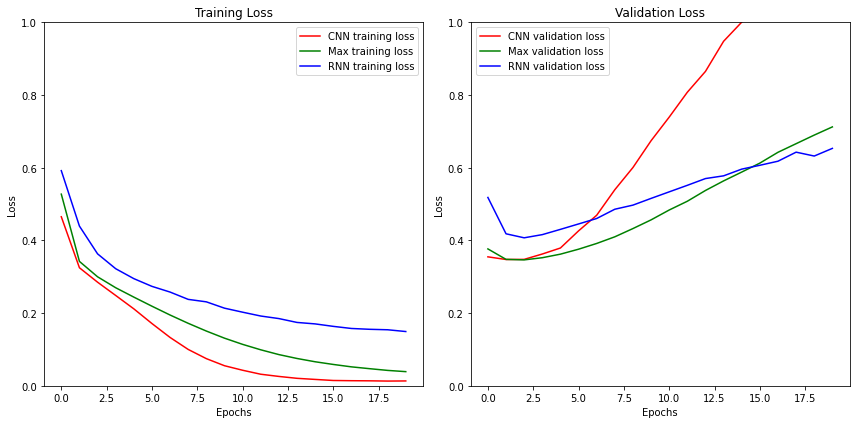

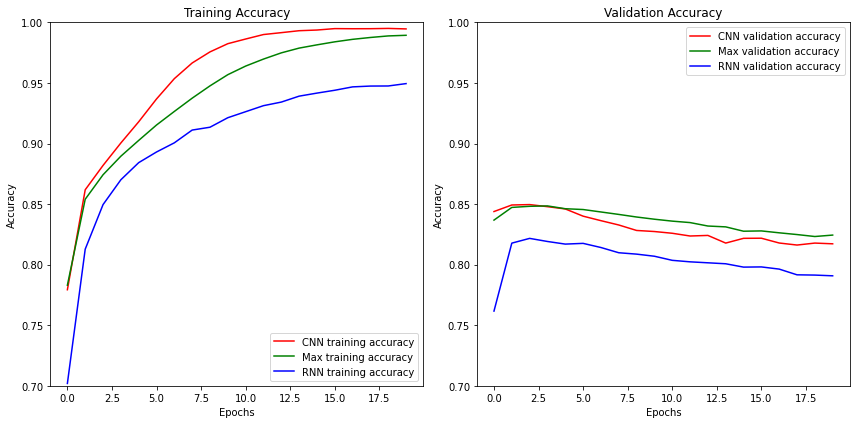

In [117]:
# 서브플롯을 사용하여 그래프 그리기
import matplotlib.pyplot as plt

# 훈련 손실 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_CNN.history['loss'], 'r', label='CNN training loss')
plt.plot(history_MAX.history['loss'], 'g', label='Max training loss')
plt.plot(history_RNN.history['loss'], 'b', label='RNN training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.0, 1.0)

# 검증 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history_CNN.history['val_loss'], 'r', label='CNN validation loss')
plt.plot(history_MAX.history['val_loss'], 'g', label='Max validation loss')
plt.plot(history_RNN.history['val_loss'], 'b', label='RNN validation loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.0, 1.0)

plt.tight_layout()
plt.show()

# 훈련 정확도 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_CNN.history['accuracy'], 'r', label='CNN training accuracy')
plt.plot(history_MAX.history['accuracy'], 'g', label='Max training accuracy')
plt.plot(history_RNN.history['accuracy'], 'b', label='RNN training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.7, 1.0)

# 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history_CNN.history['val_accuracy'], 'r', label='CNN validation accuracy')
plt.plot(history_MAX.history['val_accuracy'], 'g', label='Max validation accuracy')
plt.plot(history_RNN.history['val_accuracy'], 'b', label='RNN validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.7, 1.0)

plt.tight_layout()
plt.show()

# 7) 학습된 Embedding 레이어 분석

In [118]:
embedding_layer = model_RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [119]:
import os  # os 모듈을 임포트
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [120]:
# 자체 학습된 임베딩 레이어
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [121]:
# 사전학습 임베딩 레이어
from gensim.models import Word2Vec

word2vec_model = Word2Vec.load('/aiffel/data/word2vec_ko.model')

In [122]:
# 자체학습된 gensim의 유사단어
word_vectors.similar_by_word("사랑")

[('드니로', 0.7985155582427979),
 ('^^', 0.7840061783790588),
 ('형제', 0.7477068901062012),
 ('장벽', 0.7462812066078186),
 ('찡', 0.732694149017334),
 ('짱짱', 0.7291308045387268),
 ('어떤지', 0.727867841720581),
 ('감동', 0.7256119847297668),
 ('이틀', 0.7220360040664673),
 ('돋보이', 0.7217875719070435)]

In [123]:
# 사전학습된 gensim의 유사단어
word2vec_model.wv.most_similar("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [124]:
# 자체학습된 gensim의 유사단어
word_vectors.similar_by_word("게임")

[('때릴', 0.5582458972930908),
 ('전편', 0.553918719291687),
 ('해리슨', 0.5514690279960632),
 ('호기심', 0.5504359602928162),
 ('러시아', 0.5422943234443665),
 ('6', 0.5389261841773987),
 ('역할', 0.5337116718292236),
 ('버린', 0.5325690507888794),
 ('유오', 0.5321509838104248),
 ('싸이', 0.5290903449058533)]

In [125]:
# 사전학습된 gensim의 유사단어
word2vec_model.wv.most_similar("게임")

[('MMORPG', 0.7527816891670227),
 ('아케이드', 0.7319875955581665),
 ('콘솔', 0.7070611119270325),
 ('캡콤', 0.7049524784088135),
 ('보드게임', 0.6967473030090332),
 ('퍼즐', 0.676198422908783),
 ('롤플레잉', 0.6732538342475891),
 ('FPS', 0.6709606647491455),
 ('테트리스', 0.6659164428710938),
 ('온라인', 0.6616836190223694)]

### 사전학습된 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 확인할 수 있다.

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [126]:
vocab_size = 9000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (Word2Vec 모델의 차원 수와 일치시킵니다)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

### 한국어 Word2Vec 임베딩을 활용한 CNN 모델

In [127]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dropout

# 한국어 Word2Vec 임베딩을 활용한 CNN 모델
model_CNN_world = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                             word_vector_dim, 
                             embeddings_initializer=Constant(embedding_matrix),  
                             input_length=maxlen, 
                             trainable=True),   
    tf.keras.layers.Conv1D(16, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(16, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_CNN_world.summary()



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 41, 100)           900000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 16)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 16)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)              

In [128]:
# 한국어 Word2Vec 임베딩을 활용한 CNN 모델 학습
history_CNN_world = train_model(model_CNN_world, partial_x_train, partial_y_train, x_val, y_val, epochs=20, batch_size=512)

Epoch 1/20
188/188 [==============================] - 2s 7ms/step - loss: 0.5325 - accuracy: 0.7406 - val_loss: 0.3824 - val_accuracy: 0.8331
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3834 - accuracy: 0.8438 - val_loss: 0.3674 - val_accuracy: 0.8377
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3548 - accuracy: 0.8588 - val_loss: 0.3635 - val_accuracy: 0.8410
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3316 - accuracy: 0.8678 - val_loss: 0.3643 - val_accuracy: 0.8400
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3130 - accuracy: 0.8751 - val_loss: 0.3674 - val_accuracy: 0.8409
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2971 - accuracy: 0.8825 - val_loss: 0.3729 - val_accuracy: 0.8411
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2835 - accuracy: 0.8872 - val_loss: 0.3814 - val_accuracy: 0.8393
Epoch 

In [129]:
# 테스트셋을 통한 CNN 모델 평가
results = model_CNN_world.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5252 - accuracy: 0.8211
[0.525158166885376, 0.8211038112640381]


In [130]:
import matplotlib.pyplot as plt

# 결과 그래프 함수
def plot_history(history):
    # 훈련 손실(training loss)과 검증 손실(validation loss) 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'r--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # 훈련 정확도(training accuracy)와 검증 정확도(validation accuracy) 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'r--', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

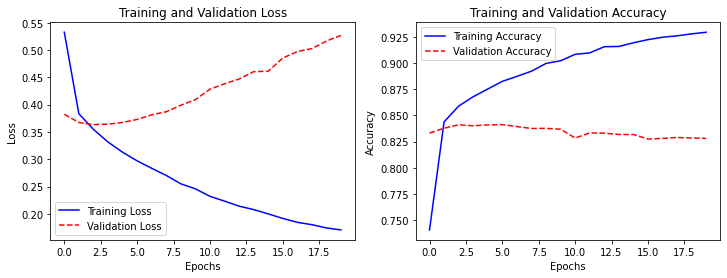

In [131]:
# 한국어 Word2Vec 임베딩을 활용한 CNN 모델 결과 그래프
plot_history(history_CNN_world)

### 한국어 Word2Vec 임베딩을 활용한 LSTM 모델

In [132]:
from tensorflow.keras.layers import LSTM, MaxPooling1D, GlobalMaxPooling1D

# 한국어 Word2Vec 임베딩을 활용한 LSTM 모델
model_LSTM_world = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                             word_vector_dim, 
                             embeddings_initializer=Constant(embedding_matrix),  
                             input_length=maxlen, 
                             trainable=True),   
    LSTM(16, return_sequences=True),  # LSTM 레이어 추가 (return_sequences=True로 설정)
    MaxPooling1D(pool_size=4),  # MaxPooling 레이어 추가
    GlobalMaxPooling1D(),  # GlobalMaxPooling 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 50%의 뉴런을 무작위로 비활성화
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_LSTM_world.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 41, 100)           900000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 41, 16)            7488      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 10, 16)            0         
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 16)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [133]:
# 한국어 Word2Vec 임베딩을 활용한 LSTM 모델 학습
history_LSTM_world = train_model(model_LSTM_world, partial_x_train, partial_y_train, x_val, y_val, epochs=20, batch_size=512)

Epoch 1/20
188/188 [==============================] - 3s 9ms/step - loss: 0.5285 - accuracy: 0.7477 - val_loss: 0.3792 - val_accuracy: 0.8331
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3808 - accuracy: 0.8435 - val_loss: 0.3679 - val_accuracy: 0.8385
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3561 - accuracy: 0.8523 - val_loss: 0.3610 - val_accuracy: 0.8401
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3359 - accuracy: 0.8613 - val_loss: 0.3568 - val_accuracy: 0.8450
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3208 - accuracy: 0.8666 - val_loss: 0.3657 - val_accuracy: 0.8456
Epoch 6/20
188/188 [==============================] - 1s 8ms/step - loss: 0.3050 - accuracy: 0.8731 - val_loss: 0.3617 - val_accuracy: 0.8455
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2980 - accuracy: 0.8779 - val_loss: 0.3632 - val_accuracy: 0.8465
Epoch 

In [134]:
# 테스트셋을 통한 LSTM 모델 평가

results = model_LSTM_world.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4784 - accuracy: 0.8310
[0.4784198999404907, 0.8310108184814453]


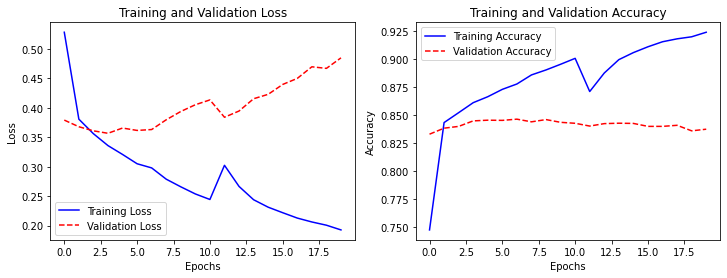

In [135]:
# 한국어 Word2Vec 임베딩을 활용한 LSTM 모델 결과 그래프
plot_history(history_LSTM_world)

### 한국어 Word2Vec 임베딩을 활용한 Bidirectional LSTM 모델

In [136]:
from tensorflow.keras.layers import Bidirectional

# 한국어 Word2Vec 임베딩을 활용한 Bidirectional LSTM 모델
model_BiLSTM_world = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                             word_vector_dim, 
                             embeddings_initializer=Constant(embedding_matrix),  
                             input_length=maxlen, 
                             trainable=True),   
    Bidirectional(LSTM(16, return_sequences=True)),  # Bidirectional LSTM 레이어 추가 (return_sequences=True로 설정)
    MaxPooling1D(pool_size=8),  # MaxPooling 레이어 추가
    GlobalMaxPooling1D(),  # GlobalMaxPooling 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 50%의 뉴런을 무작위로 비활성화
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_BiLSTM_world.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 41, 100)           900000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 41, 32)            14976     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [137]:
# 한국어 Word2Vec 임베딩을 활용한 Bidirectional LSTM  모델 학습
history_BILSTM_world = train_model(model_BiLSTM_world, partial_x_train, partial_y_train, x_val, y_val, epochs=20, batch_size=512)

Epoch 1/20
188/188 [==============================] - 5s 14ms/step - loss: 0.4587 - accuracy: 0.7896 - val_loss: 0.3604 - val_accuracy: 0.8419
Epoch 2/20
188/188 [==============================] - 2s 10ms/step - loss: 0.3411 - accuracy: 0.8587 - val_loss: 0.3579 - val_accuracy: 0.8432
Epoch 3/20
188/188 [==============================] - 2s 10ms/step - loss: 0.3200 - accuracy: 0.8678 - val_loss: 0.3514 - val_accuracy: 0.8462
Epoch 4/20
188/188 [==============================] - 2s 10ms/step - loss: 0.3024 - accuracy: 0.8758 - val_loss: 0.3549 - val_accuracy: 0.8467
Epoch 5/20
188/188 [==============================] - 2s 10ms/step - loss: 0.2876 - accuracy: 0.8817 - val_loss: 0.3503 - val_accuracy: 0.8481
Epoch 6/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2732 - accuracy: 0.8873 - val_loss: 0.3579 - val_accuracy: 0.8469
Epoch 7/20
188/188 [==============================] - 2s 10ms/step - loss: 0.2587 - accuracy: 0.8949 - val_loss: 0.3816 - val_accuracy: 0.8455


In [138]:
# 테스트셋을 통한 Bidirectional LSTM 모델 평가
results = model_BiLSTM_world.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5249 - accuracy: 0.8336
[0.5248950719833374, 0.8336350917816162]


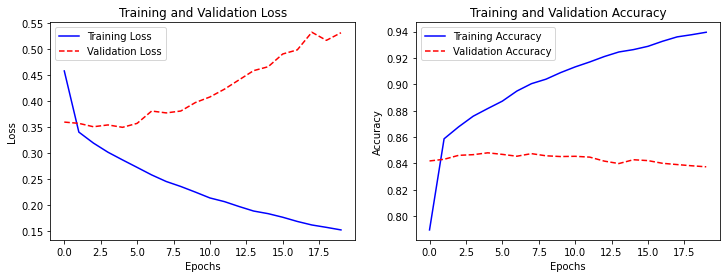

In [139]:
# 한국어 Word2Vec 임베딩을 활용한 Bidirectional LSTM 모델 결과 그래프
plot_history(history_BILSTM_world)

### 한국어 Word2Vec 임베딩을 활용한 CNN-LSTM 모델

In [140]:
from tensorflow.keras.layers import Conv1D, LSTM

# 한국어 Word2Vec 임베딩을 활용한 CNN-LSTM 모델
model_CNN_LSTM_world = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                             word_vector_dim, 
                             embeddings_initializer=Constant(embedding_matrix),  
                             input_length=maxlen, 
                             trainable=True),   
    Conv1D(16, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(3),
    tf.keras.layers.Dropout(0.5),
    LSTM(16),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model_CNN_LSTM_world.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 41, 100)           900000    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 11, 16)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 11, 16)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)               

In [141]:
# 한국어 Word2Vec 임베딩을 활용한 CNN-LSTM 모델 학습
history_CNN_LSTM_world = train_model(model_CNN_LSTM_world, partial_x_train, partial_y_train, x_val, y_val, epochs=20, batch_size=512)

Epoch 1/20
188/188 [==============================] - 3s 9ms/step - loss: 0.5687 - accuracy: 0.7060 - val_loss: 0.4093 - val_accuracy: 0.8294
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3811 - accuracy: 0.8449 - val_loss: 0.3724 - val_accuracy: 0.8366
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3435 - accuracy: 0.8610 - val_loss: 0.3677 - val_accuracy: 0.8385
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3236 - accuracy: 0.8691 - val_loss: 0.3668 - val_accuracy: 0.8404
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3052 - accuracy: 0.8779 - val_loss: 0.3633 - val_accuracy: 0.8420
Epoch 6/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2870 - accuracy: 0.8859 - val_loss: 0.3699 - val_accuracy: 0.8409
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2711 - accuracy: 0.8923 - val_loss: 0.3803 - val_accuracy: 0.8388
Epoch 

In [142]:
# 테스트셋을 통한 CNN-LSTM 모델 평가
results = model_CNN_LSTM_world.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5152 - accuracy: 0.8243
[0.5152360200881958, 0.8243383169174194]


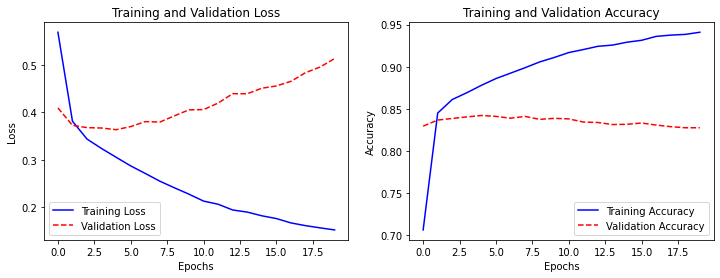

In [143]:
# 한국어 Word2Vec 임베딩을 활용한 CNN-LSTM 모델 결과 그래프
plot_history(history_CNN_LSTM_world)

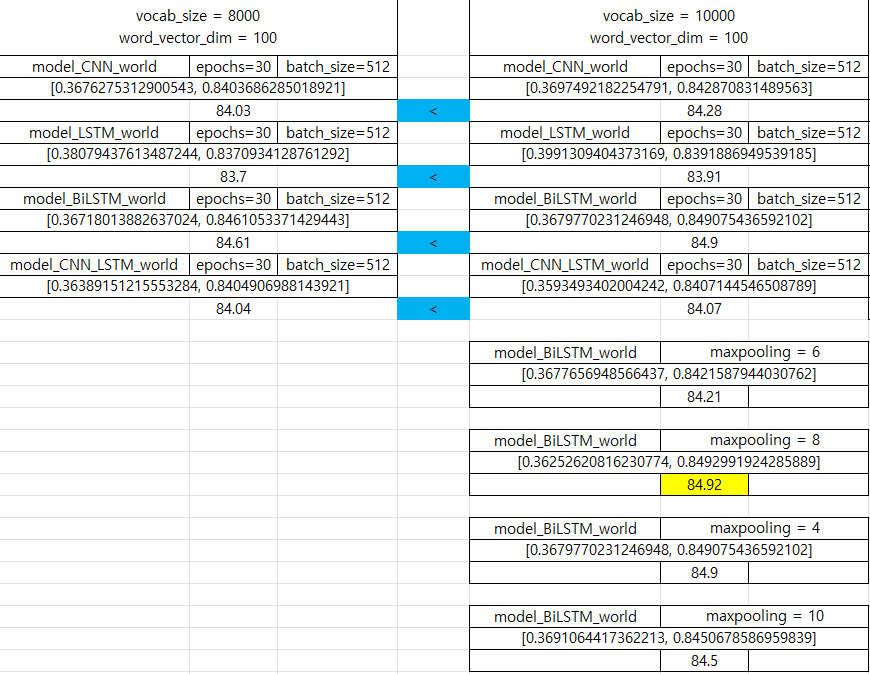

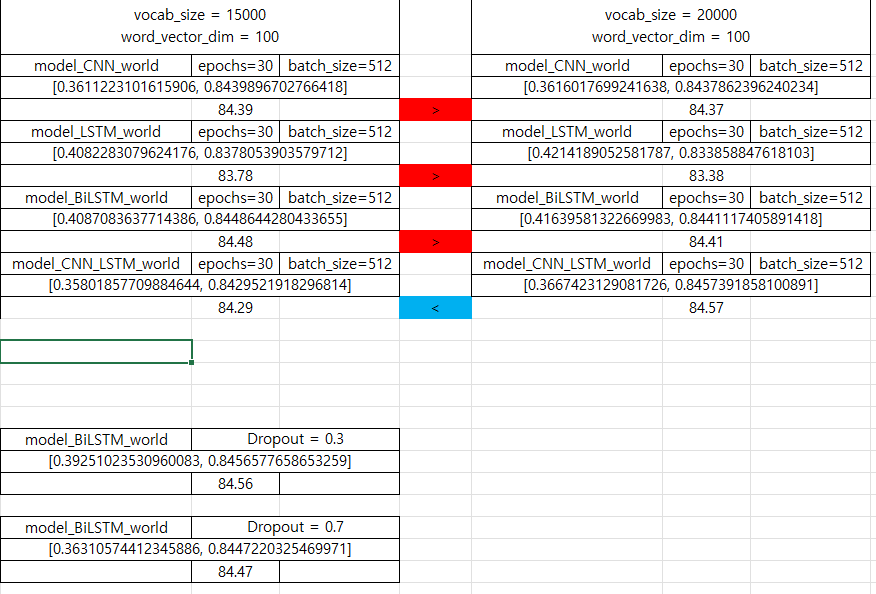

- 여러 하이퍼파라미터를 바꾸면서 실행을 해본 결과 Bidirectional LSTM에서 
- vocab_size = 10000, word_vector_dim = 100, epochs = 30, batch_size = 512, maxpooling = 8, Dropout = 0.5
- 일 때 84.92%가 나왔다.

# 회고

- 영화 리뷰를 통한 텍스트 감성분석을 해보니 재미있었다. 
- 아직까지는 너무 재미있어서 욕이 리뷰 텍스트에 들어있으면 부정일지 긍정일지에 대해서는 조금더 고민해보아야할 것 같고, 예상보다 85%를 넘기지를 못해서 여러 하이퍼파라미터를 변경하면서 진행해보았지만 성능에 만족하지 못한게 너무 아쉽다.
- 모델 공부를 더 해서 다른 모델이나 다른 하이퍼파라미터를 만져 성능에 만족해보겠다.